In [1]:
# import tensorflow as tf

# # Limit GPU memory usage
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.set_logical_device_configuration(
#                 gpu,
#                 [tf.config.LogicalDeviceConfiguration(memory_limit=(7 * 1024))])
#         logical_gpus = tf.config.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         print(e)

In [17]:
import json
import os

import pandas as pd
import numpy as np

def read_json_to_df(file_name):
    data = []
    with open(file_name) as data_file:
        for line in data_file:
            # Load each line of the JSON file as a dictionary
            data.append(json.loads(line))

    # Form a Pandas DataFrame from the dictionaries
    return pd.json_normalize(data)

# Load the training and test data
raw_train_df = read_json_to_df("hotel_reviews_train.json")
raw_test_df = read_json_to_df("hotel_reviews_test.json")

ratings_columns = [col for col in raw_train_df.columns if col.startswith("ratings.")]

# Select the title, text and overall rating columns to make a new dataframe
train_df = raw_train_df[["title", "text"] + ratings_columns]
test_df = raw_test_df[["title", "text"] + ratings_columns]

# Save the English reviews to a CSV file to save time filtering when running again (NumFOCUS, Inc. 2024)
if os.path.exists("english_hotel_reviews_train.csv"):
    train_df = pd.read_csv("english_hotel_reviews_train.csv")

if os.path.exists("english_hotel_reviews_test.csv"):
    test_df = pd.read_csv("english_hotel_reviews_test.csv")

train_df_2 = train_df.fillna(0)

inputs = train_df_2[ratings_columns]
# outputs = train_df_2['title'] + ' ' + train_df_2['text']
outputs = train_df_2['text']

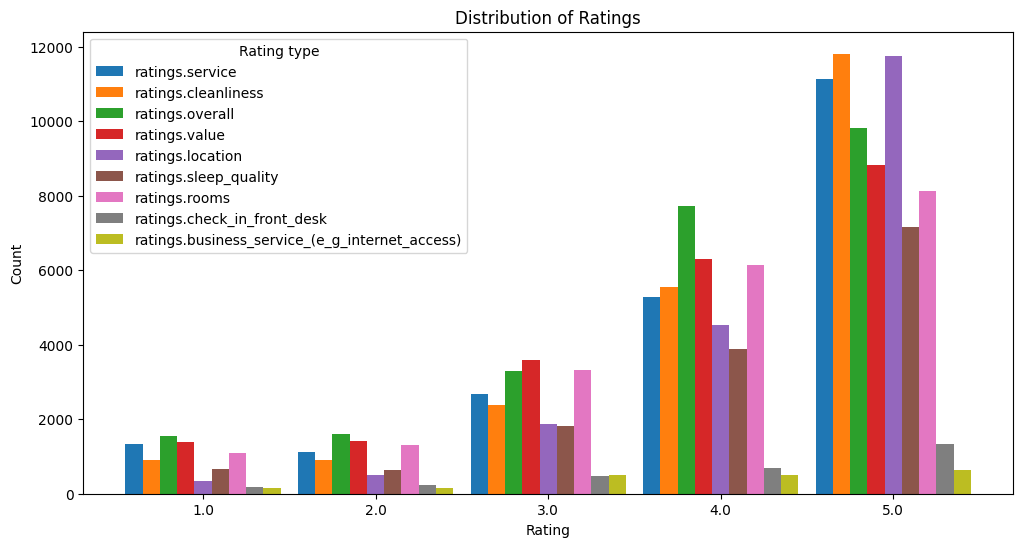

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

rating_counts = pd.DataFrame({
    col: train_df[col].value_counts().sort_index() for col in ratings_columns
})

bar_width = 0.15
group_spacing = 1.5
indices = np.arange(len(rating_counts)) * group_spacing

for i, column in enumerate(rating_counts.columns):
    plt.bar(indices + i * bar_width, rating_counts[column], width=bar_width, label=column)

plt.xticks(indices + bar_width * (len(ratings_columns) - 1) / 2, rating_counts.index)

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.legend(title="Rating type")
plt.show()

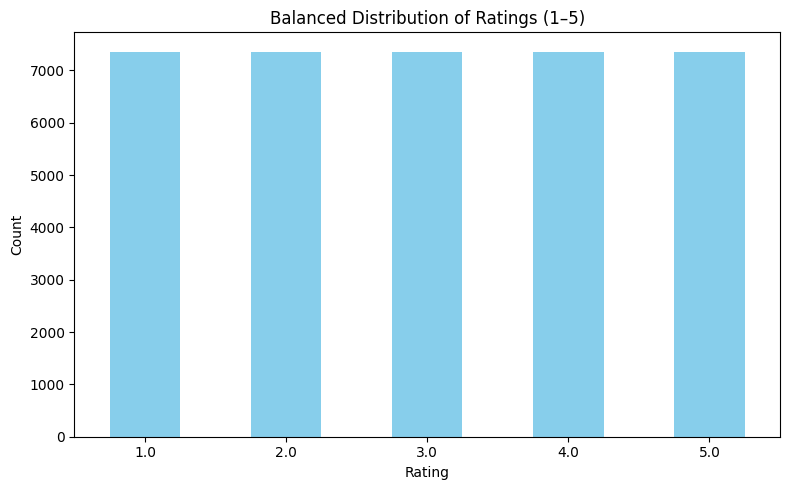

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter to keep only ratings from 1 to 5
train_df_filtered = train_df[train_df['ratings.overall'].isin([1, 2, 3, 4, 5])]

# Balance the training data by oversampling
def balance_data_oversample(df, rating_col='ratings.overall'):
    max_count = df[rating_col].value_counts().max()
    balanced_df = pd.DataFrame()

    for rating in sorted(df[rating_col].unique()):
        rating_df = df[df[rating_col] == rating]
        # Oversample each group to match the largest one
        sampled_df = rating_df.sample(max_count, replace=True, random_state=42)
        balanced_df = pd.concat([balanced_df, sampled_df], axis=0)

    return balanced_df.reset_index(drop=True)

# Apply balancing
balanced_train_df = balance_data_oversample(train_df_filtered)

# Plot distribution
balanced_train_df['ratings.overall'].value_counts().sort_index().plot(
    kind='bar',
    figsize=(8, 5),
    color='skyblue'
)

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Balanced Distribution of Ratings (1–5)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


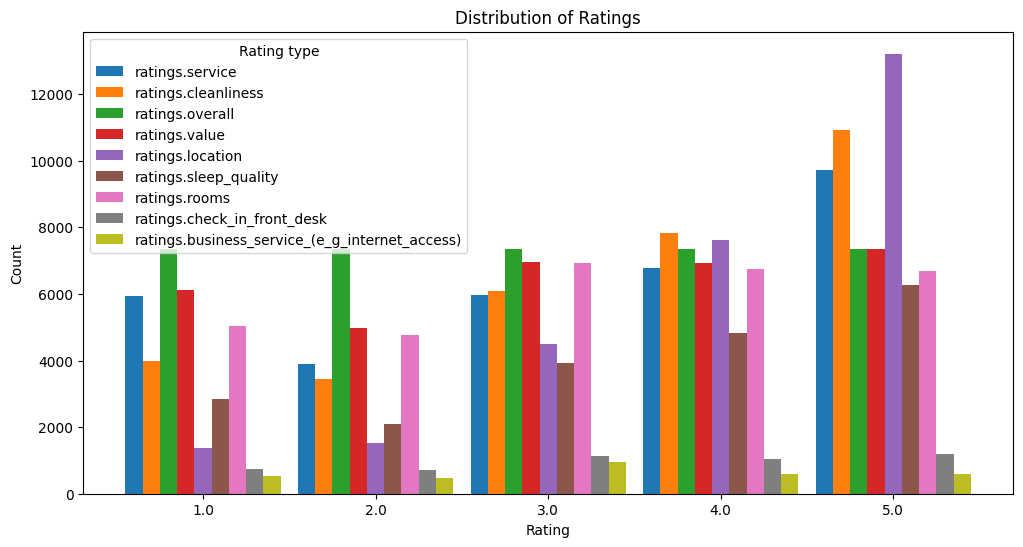

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

rating_counts = pd.DataFrame({
    col: balanced_train_df[col].value_counts().sort_index() for col in ratings_columns
})

bar_width = 0.15
group_spacing = 1.5
indices = np.arange(len(rating_counts)) * group_spacing

for i, column in enumerate(rating_counts.columns):
    plt.bar(indices + i * bar_width, rating_counts[column], width=bar_width, label=column)

plt.xticks(indices + bar_width * (len(ratings_columns) - 1) / 2, rating_counts.index)

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.legend(title="Rating type")
plt.show()

In [6]:
def format_input(rating) -> str:
    input = "Generate a hotel review based on the following ratings:\n"
    service = rating.iloc[0]
    cleanliness = rating.iloc[1]
    overall = rating.iloc[2]
    value = rating.iloc[3]
    location = rating.iloc[4]
    sleep_quality = rating.iloc[5]
    rooms = rating.iloc[6]
    check_in_front_desk = rating.iloc[7]
    business_service = rating.iloc[8]

    if service != 0:
      input += f"- service: {service}\n"
    if cleanliness != 0:
      input += f"- cleanliness: {cleanliness}\n"
    if overall != 0:
      input += f"- overall: {overall}\n"
    if value != 0:
      input += f"- value: {value}\n"
    if location != 0:
      input += f"- location: {location}\n"
    if sleep_quality != 0:
      input += f"- sleep quality: {sleep_quality}\n"
    if rooms != 0:
      input += f"- rooms: {rooms}\n"
    if check_in_front_desk != 0:
      input += f"- check in: {check_in_front_desk}\n"
    if business_service != 0:
      input += f"- business service: {business_service}\n"

    input += "Review: "

    return input

In [7]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Load the GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

# Set the maximum length of the generated text
max_length = 200

# Define the input prompt
prompt = format_input(inputs.iloc[0])

# Encode the input prompt using the tokenizer
input_ids = tokenizer.encode(prompt, return_tensors='pt')

# Generate the text using the GPT-2 model
output_ids = model.generate(input_ids=input_ids, max_length=max_length, do_sample=True)

# Decode the generated text using the tokenizer
output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Print the generated text
print(output_text)

2025-05-17 14:55:44.371215: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 14:55:44.382575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747459544.395226   60802 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747459544.398609   60802 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747459544.408462   60802 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Generate a hotel review based on the following ratings:
- service: 4.0
- cleanliness: 5.0
- overall: 4.0
- value: 3.0
- location: 5.0
- sleep quality: 4.0
- rooms: 4.0
Review:  a nice hotel review. So here is my experience in the past and see what I found. If you have seen some other reviews on my site where the room was clean, or checked out of the rental price, I would be highly pleased. I am quite surprised at what other reviews said which can only be the answer to this question. For me and many others, I did have to see and evaluate a room in order to make a judgment here. This is a very small price of a small room, plus all the other reviews who were just asking me how much I would pay for bed or bathroom for just a short term. And, all the same,


## Training

In [8]:
train_df_new = pd.DataFrame()
train_df_new['prompt'] = balanced_train_df[ratings_columns].apply(format_input, axis=1)
train_df_new['completion'] = balanced_train_df['text']

texts = train_df_new.apply(lambda row: row['prompt'] + " " + row['completion'], axis=1).tolist()

In [9]:
print(texts[0])

Generate a hotel review based on the following ratings:
- service: 2.0
- cleanliness: 3.0
- overall: 1.0
- value: 1.0
- location: 3.0
- sleep quality: nan
- rooms: 1.0
- check in: nan
- business service: nan
Review:  i recently booked some clients in july 09 i picked them up at the airport and took them to the grand resort when i checked them in i was hit with a 3000 per person per day fee that they refused to take off this was not on the reservation and i had to fork up the money at check out i picked this hotel because of the location to my business we had no intenion of going on the waterslide they told me that this fee is for passes to the waterslide i advised them that we would not be using it and they rudely refused to take it off the bill 
watch out if you book this resort on hotelscom or similar services this fee does not show up on the booking price


In [10]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from datasets import Dataset
from transformers import DataCollatorForLanguageModeling

# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Add padding token if not present (GPT-2 doesn't have one by default)
tokenizer.pad_token = tokenizer.eos_token
model.resize_token_embeddings(len(tokenizer))

# Convert to HF dataset
dataset = Dataset.from_dict({"text": texts[:100]})

# Tokenize
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=max_length)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [11]:
import torch

torch.cuda.empty_cache()

In [12]:
texts[0]

'Generate a hotel review based on the following ratings:\n- service: 2.0\n- cleanliness: 3.0\n- overall: 1.0\n- value: 1.0\n- location: 3.0\n- sleep quality: nan\n- rooms: 1.0\n- check in: nan\n- business service: nan\nReview:  i recently booked some clients in july 09 i picked them up at the airport and took them to the grand resort when i checked them in i was hit with a 3000 per person per day fee that they refused to take off this was not on the reservation and i had to fork up the money at check out i picked this hotel because of the location to my business we had no intenion of going on the waterslide they told me that this fee is for passes to the waterslide i advised them that we would not be using it and they rudely refused to take it off the bill \nwatch out if you book this resort on hotelscom or similar services this fee does not show up on the booking price'

In [13]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
from datasets import Dataset
from transformers import DataCollatorForLanguageModeling

# Load tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model.resize_token_embeddings(len(tokenizer))

# Prepare dataset
dataset = Dataset.from_dict({"text": texts})

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=max_length)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

training_args = TrainingArguments(
    output_dir="./gpt2-hotel-finetuned",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_device_train_batch_size=8,
    #gradient_accumulation_steps=4,
    logging_dir="./logs",
    save_steps=500,
    save_total_limit=2,
    prediction_loss_only=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
)

trainer.train()


Map:   0%|          | 0/36805 [00:00<?, ? examples/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss


KeyboardInterrupt: 

In [ ]:
print(dataset['text'][0])

In [ ]:
model.save_pretrained("./gpt2-hotel-finetuned")
tokenizer.save_pretrained("./gpt2-hotel-finetuned")


In [ ]:
test_input = pd.Series([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [ ]:
# Sample prompt: turn ratings into a prompt
prompt = format_input(test_input)

input_ids = tokenizer.encode(prompt, return_tensors='pt').to('cuda')

generated_ids = model.generate(
    input_ids,
    max_length=max_length,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    temperature=0.7,
    pad_token_id=tokenizer.eos_token_id
)

print(tokenizer.decode(generated_ids[0], skip_special_tokens=True))
